In [11]:
from molmap import dataset
from molmap import loadmap
import molmap

import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)

import numpy as np
import tensorflow as tf

#use the second GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


%matplotlib inline
np.random.seed(777)
tf.set_random_seed(777)


def get_deepchem_idx(df):
    """ deepchem dataset"""
    deepchem_data_name = './SIDER_deepchem.data'
    if os.path.exists(deepchem_data_name):
        train_df,valid_df,test_df = load(deepchem_data_name)
    else:
        import deepchem as dc
        task, train_valid_test, _ = dc.molnet.load_sider(featurizer='Raw',split = 'random')
        train, valid, test = train_valid_test
        train_df = df[df.smiles.isin(train.ids)]
        valid_df = df[df.smiles.isin(valid.ids)]
        test_df = df[df.smiles.isin(test.ids)]
        dump((train_df,valid_df,test_df), deepchem_data_name)
    train_idx = train_df.index
    valid_idx = valid_df.index
    test_idx = test_df.index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx


def get_attentiveFP_idx(df):
    """ attentiveFP dataset"""
    train, valid,test = load('./SIDER_attentiveFP.data')
    print('training set: %s, valid set: %s, test set %s' % (len(train), len(valid), len(test)))
    train_idx = df[df.smiles.isin(train.smiles)].index
    valid_idx = df[df.smiles.isin(valid.smiles)].index
    test_idx = df[df.smiles.isin(test.smiles)].index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx 

def get_pos_weights(trainY):
    """pos_weights: neg_n / pos_n """
    dfY = pd.DataFrame(trainY)
    pos = dfY == 1
    pos_n = pos.sum(axis=0)
    neg = dfY == 0
    neg_n = neg.sum(axis=0)
    pos_weights = (neg_n / pos_n).values
    neg_weights = (pos_n / neg_n).values
    return pos_weights, neg_weights

In [12]:
#load dataset
data = dataset.load_SIDER()
df = data.data

total samples: 1427


In [13]:
MASK = -1
Y = pd.DataFrame(data.y).fillna(MASK).values

In [14]:
# calculate feature
X1_name =  './descriptor_grid_split.data'
X2_name =  './fingerprint_grid_split.data'

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    mp = loadmap('../../descriptor_grid_split.mp')
    X1 = mp.batch_transform(data.x, n_jobs = 8)
    dump(X1, X1_name)
    
if os.path.exists(X2_name):
    X2 = load(X2_name)
else:
    mp = loadmap('../../fingerprint_grid_split.mp')
    X2 = mp.batch_transform(data.x, n_jobs = 8)
    dump(X2, X2_name)

In [15]:
train_idx, valid_idx, test_idx = get_attentiveFP_idx(df)
#train_idx, valid_idx, test_idx = get_deepchem_idx(df)


trainX = (X1[train_idx], X2[train_idx])
trainY = Y[train_idx]

validX = (X1[valid_idx], X2[valid_idx])
validY = Y[valid_idx]

testX = (X1[test_idx], X2[test_idx])
testY = Y[test_idx]

print(len(train_idx), len(valid_idx), len(test_idx))

training set: 1092, valid set: 137, test set 137
training set: 1092, valid set: 137, test set 137
1092 137 137


In [16]:
from loss import cross_entropy, weighted_cross_entropy
from cbks import EarlyStoppingAndPerformance
from model import DoublePathClassificationModel

molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]
pos_weights, neg_weights = get_pos_weights(Y[train_idx])
loss = lambda y_true, y_pred: weighted_cross_entropy(y_true,y_pred, pos_weights, MASK)
model = DoublePathClassificationModel(molmap1_size,molmap2_size, n_outputs = Y.shape[1])

In [17]:
earlystop = EarlyStoppingAndPerformance((trainX, trainY), (validX, validY), MASK, patience=10, criteria = 'val_auc')
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = lr, loss = loss)
model.count_params()

784827

In [18]:
model.fit(trainX, trainY, batch_size=128,
      epochs=500, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[earlystop]) 

epoch: 0001, loss: 0.5977 - val_loss: 0.6205; auc: 0.5568 - val_auc: 0.5285                                                                                                    
epoch: 0002, loss: 0.5957 - val_loss: 0.6206; auc: 0.5840 - val_auc: 0.5321                                                                                                    
epoch: 0003, loss: 0.5946 - val_loss: 0.6215; auc: 0.6054 - val_auc: 0.5428                                                                                                    
epoch: 0004, loss: 0.5934 - val_loss: 0.6186; auc: 0.6089 - val_auc: 0.5411                                                                                                    
epoch: 0005, loss: 0.5926 - val_loss: 0.6198; auc: 0.6188 - val_auc: 0.5525                                                                                                    
epoch: 0006, loss: 0.5921 - val_loss: 0.6213; auc: 0.6285 - val_auc: 0.5533                                             

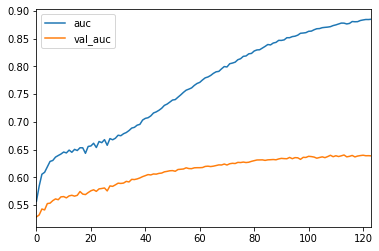

In [21]:
dfp = pd.DataFrame(earlystop.history)[[ 'auc', 'val_auc']]
dfp.plot()

In [20]:
train_auc = np.nanmean(earlystop.evaluate(trainX, trainY))
valid_auc = np.nanmean(earlystop.evaluate(validX, validY))
test_auc = np.nanmean(earlystop.evaluate(testX, testY))


print(train_auc, valid_auc, test_auc)

0.8778077242895356 0.6401360231261612 0.6930307329312773
